In [1]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import feature_extractor as f_extr

Мотивация применения простых методов классификации состоит в том, что 2D сверточные сети ищут визуальные признаки - линии, структуры и прочее, хотя из примеров разливов видно, что из характерных признаков разлива можно отметить разве что перепад цвета относительно воды. Для обработки всех каналов изображения вместе можно использовать 3D свертки, однако сперва в качестве Baseline решения имеет смысл опробовать простые классификаторы, которые будут делать выводы о принадлжености пикселя изображения к разливу на основе цвета.

# 1. Подготовка данных

In [2]:
test_data_path = '../../../final_dataset/test'

test_images_path = os.path.join(test_data_path, 'images')
test_labels_path = os.path.join(test_data_path, 'labels')

In [3]:
images_loc_paths = os.listdir(test_images_path)

In [4]:
for ilp in images_loc_paths:
    file_name = '.'.join(ilp.split('.')[:-1])
    img_p = os.path.join(test_images_path, ilp)
    lbl_p = os.path.join(test_labels_path, f'{file_name}.txt')
    
    break

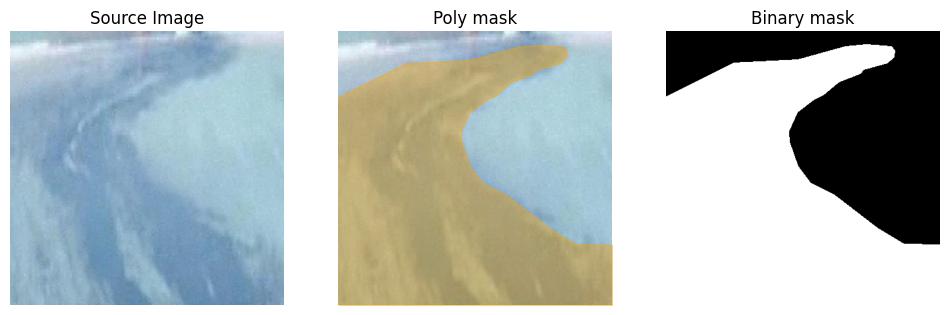

In [5]:
f_extr.vis_label(img_p, lbl_p)

In [6]:
# Попиксельное извлечение признаков:
df_pixel = f_extr.get_pixelwise_features(img_p, lbl_p)

pd.concat([
    df_pixel.head(3),
    df_pixel.tail(3)
])

,R,G,B,spill
0,160,198,209,0
1,158,196,207,0
2,155,193,204,0
173053,131,165,190,1
173054,128,162,187,1
173055,128,162,187,1


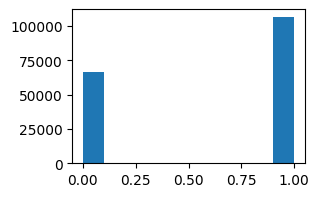

In [7]:
fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(df_pixel['spill'])
plt.show()

In [8]:
def make_table_from_ds(ds_path):
    test_images_path = os.path.join(ds_path, 'images')
    test_labels_path = os.path.join(ds_path, 'labels')
    images_loc_paths = os.listdir(test_images_path)
    df_ds = pd.DataFrame()
    for ilp in tqdm(images_loc_paths, total=len(images_loc_paths)):
        file_name = '.'.join(ilp.split('.')[:-1])
        img_p = os.path.join(test_images_path, ilp)
        lbl_p = os.path.join(test_labels_path, f'{file_name}.txt')
        df_ds = pd.concat(
            [df_ds, f_extr.get_pixelwise_features(img_p, lbl_p)]
        )
    return df_ds

In [9]:
# Подготовка датасетов:
train_data_path = '../../../final_dataset/train'
test_data_path = '../../../final_dataset/test'
valid_data_path = '../../../final_dataset/valid'

df_train = make_table_from_ds(train_data_path)
df_test = make_table_from_ds(test_data_path)
df_valid = make_table_from_ds(valid_data_path)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

df_train.to_csv(
    os.path.join(train_data_path, 'train.csv'),
    index=False
)

df_test.to_csv(
    os.path.join(test_data_path, 'test.csv'),
    index=False
)

df_valid.to_csv(
    os.path.join(valid_data_path, 'valid.csv'),
    index=False
)

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_train = pd.read_csv('../../../final_dataset/train/train.csv')
df_test = pd.read_csv('../../../final_dataset/test/test.csv')
df_valid = pd.read_csv('../../../final_dataset/valid/valid.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103719936 entries, 0 to 103719935
Data columns (total 4 columns):
 #   Column  Dtype
---  ------  -----
 0   R       int64
 1   G       int64
 2   B       int64
 3   spill   int64
dtypes: int64(4)
memory usage: 3.1 GB


По памяти не так страшно, как могло бы быть, но все равно не очень приятно.

In [7]:
half_train_n = df_train.shape[0] // 2

In [9]:
df_train = df_train.sample(half_train_n, random_state=0)

# 2. Модели

## Логистическая регрессия

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [11]:
logistic_regression = LogisticRegression()

In [12]:
logistic_regression.fit(
    df_train[['R', 'G', 'B']], df_train['spill']
)

LogisticRegression()

In [14]:
y_pred = logistic_regression.predict(df_test[['R', 'G', 'B']])

In [15]:
f1_score(df_test['spill'], y_pred)

0.4829116524174743

In [21]:
import cv2
import matplotlib.pyplot as plt

In [62]:
test_image = cv2.cvtColor(
    # cv2.imread('../../../final_dataset/train/images/27_jpg.rf.6c1f98e16ce916de0d127a972f2b314f.jpg'),
    cv2.imread('../../../final_dataset/test/images/61_jpg.rf.d8db0728f1250b2337f7b9f0d2596b64.jpg'),
    # cv2.imread('test_image.jpg'),
    cv2.COLOR_BGR2RGB
)

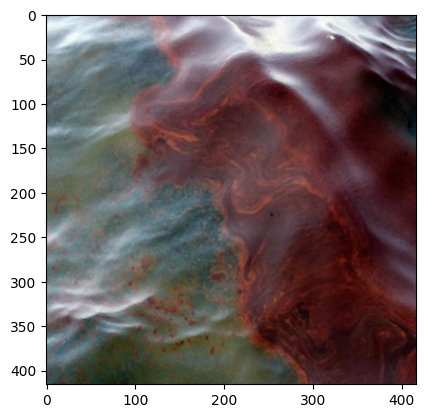

In [63]:
plt.imshow(test_image)

In [64]:
t_img_h, t_img_w, t_img_ch = test_image.shape
test_img_df = pd.DataFrame(
    test_image.reshape(t_img_h * t_img_w, t_img_ch),
    columns=['R', 'G', 'B']
)

In [65]:
test_img_y_pred = logistic_regression.predict(
    test_img_df[['R', 'G', 'B']]
)

In [66]:
test_img_mask = test_img_y_pred.reshape(t_img_h, t_img_w, 1)

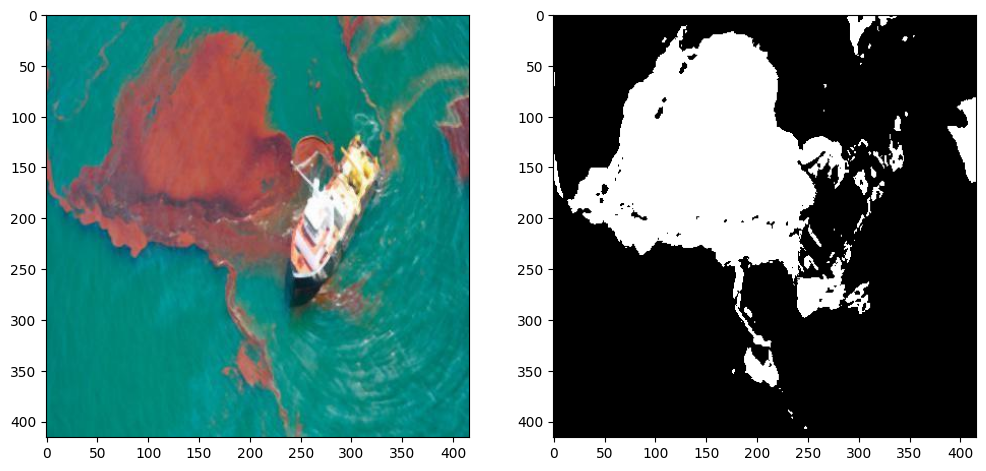

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(test_image)
ax[1].imshow(test_img_mask*255, 'gray')

plt.show()

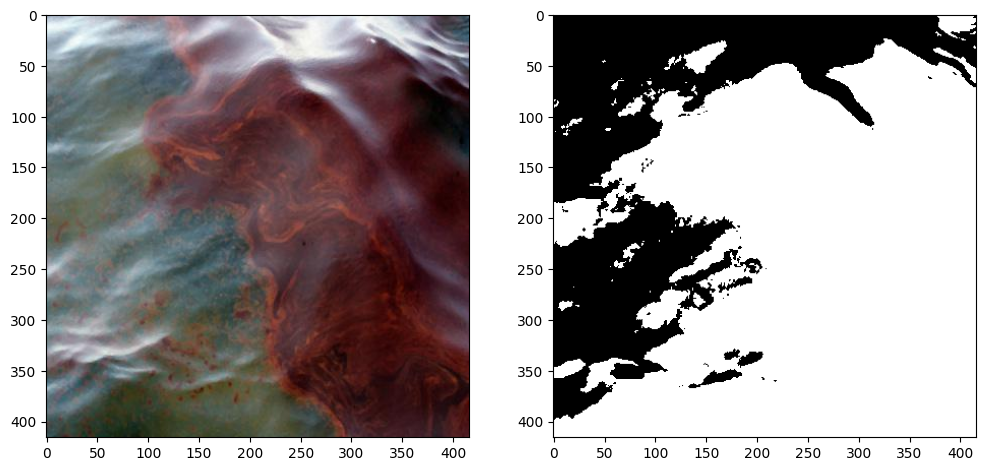

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(test_image)
ax[1].imshow(test_img_mask*255, 'gray')

plt.show()

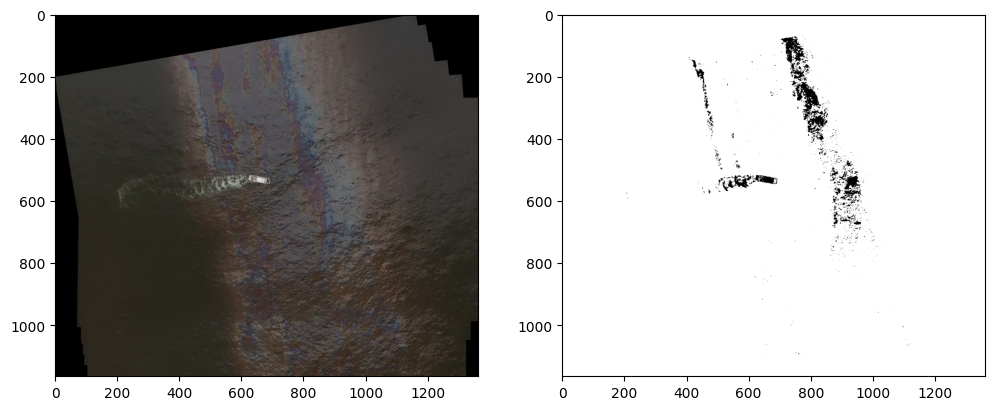

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(test_image)
ax[1].imshow(test_img_mask*255, 'gray')

plt.show()

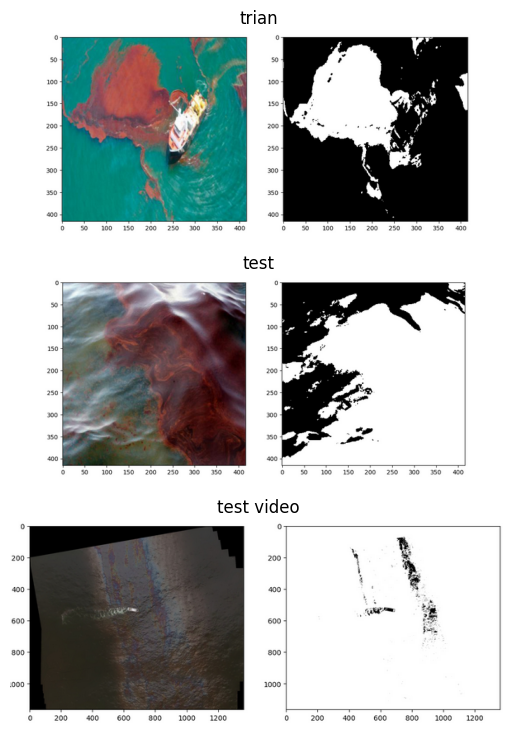

In [75]:
fig, ax = plt.subplots(3, 1, figsize=(12, 9))

images_names = [
    '2023-03-27_15-08.png',
    '2023-03-27_15-09.png',
    '2023-03-27_15-09_1.png'
]

images_meaning = [
    'trian',
    'test',
    'test video'
]

for i, im_n in enumerate(images_names):
    img = cv2.imread(f'../../../log_reg/{im_n}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(images_meaning[i])

plt.show()